# Multi-series forecasting

In [1]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

/home/dev/miniconda3/envs/pf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

In [13]:
series_air.pd_dataframe()

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [14]:
series_milk.pd_dataframe()

component,Pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


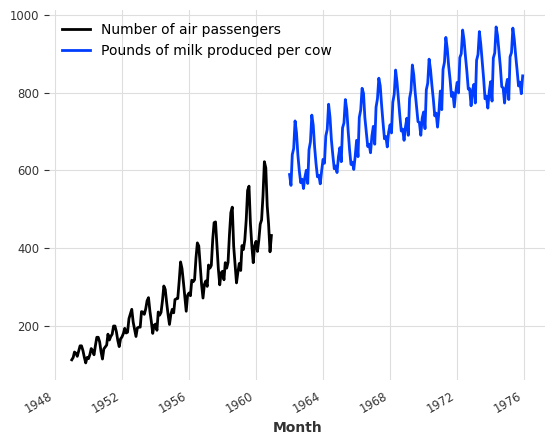

In [2]:
series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

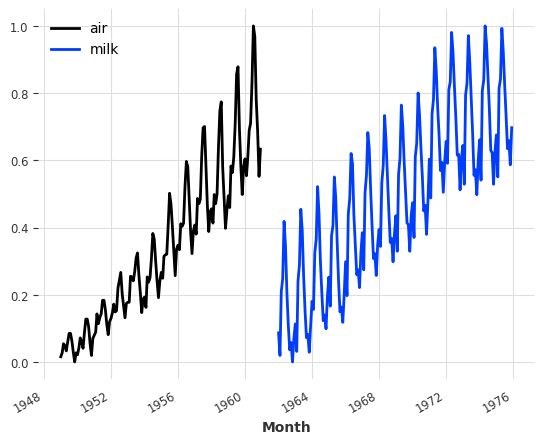

In [3]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend()

In [4]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

In [5]:
model_air_milk = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0
)

In [6]:
model_air_milk.fit([train_air, train_milk], verbose=True);

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 26.63it/s, train_loss=0.00025] 


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.40it/s]
MAPE = 8.35%


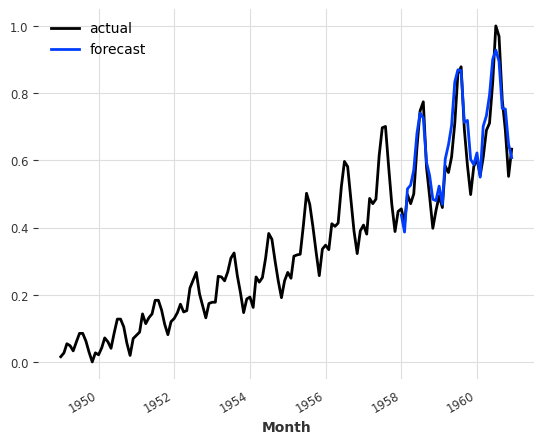

In [7]:
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.93it/s] 


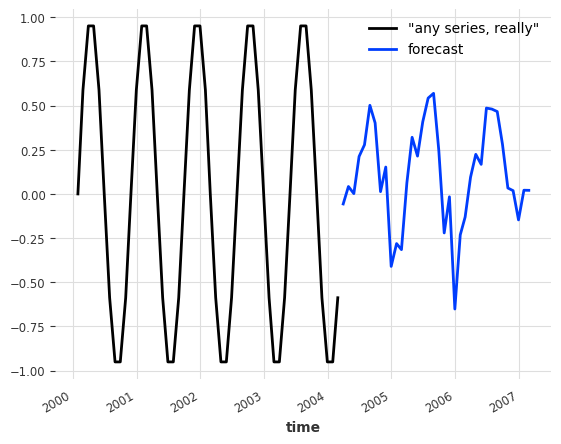

In [8]:
any_series = sine_timeseries(length=50, freq="M")
pred = model_air_milk.predict(n=36, series=any_series)

any_series.plot(label='"any series, really"')
pred.plot(label="forecast")
plt.legend()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.64it/s]


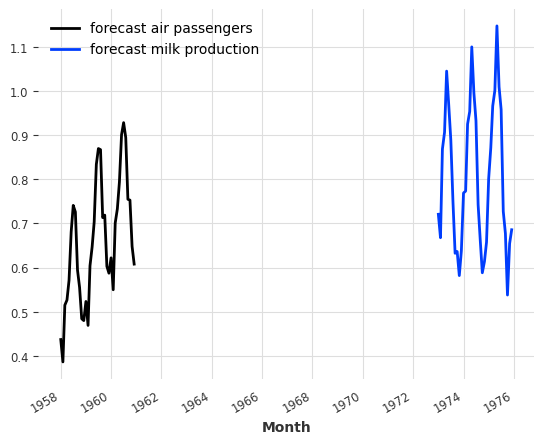

In [9]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend();